In [2]:
import pandas as pd
from scripts.convert_to_excel import match, dematch

In [3]:
df_1 = pd.read_json('data/pwc_s2_cleaned_text.jsonl', lines=True)

In [4]:
len(df_1['task'].unique())

216

In [5]:
df = pd.read_json('outputs/sampled_for_labelling.jsonl', lines=True)

In [6]:
from openpyxl import load_workbook

In [7]:
wb = load_workbook('outputs/data_for_annotation_final.xlsx')
sh1 = wb['Sheet1']

In [8]:
from collections import defaultdict
json_vals = defaultdict(dict)
predicted_entity_cols = list(range(6, 218))
for row in range(2, 41 + 1) :
    row_id = sh1.cell(row, 2).value
    entity_type = sh1.cell(row, 3).value
    val = {'true_entities' : sh1.cell(row, 4).value.split(',') }
    predicted_entities = [sh1.cell(row, x) for x in predicted_entity_cols]
    predicted_entities = [(x.value, True if x.fill.bgColor.rgb != '00000000' else False) for x in predicted_entities if x.value is not None]
    val['predicted'] = predicted_entities
    json_vals[row_id][entity_type + '_labeled'] = val['true_entities']
    json_vals[row_id][dematch[entity_type] + '_labeled'] = val['predicted']

In [9]:
import pandas as pd
df_labeled = pd.DataFrame(json_vals).transpose().reset_index().rename(columns={'index' : 's2_paper_id'})

In [10]:
merged_df = df.merge(df_labeled, on='s2_paper_id')

In [43]:
import re

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

clean_text = lambda w : re.sub(r'\s+', ' ', re.sub(r'[^\w\s\.]', ' ', w)).split()
get_n_grams = lambda w_list, n : [w[i:i+n] for w in w_list for i in range(len(w)-n+1)]
get_abbr_n_grams = lambda w_list, n : ["".join([w[0] for w in w_list[i:i+n]]) for i in range(len(w_list)-n+1)]

def char_sim(w1:str, w2:str, ng:int = 3, with_abbr:bool = False) :
    w1, w2 = clean_text(w1), clean_text(w2)
    ng = min(min([len(x) for x in w1 + w2]), ng)
    score_1 = jaccard_similarity(get_n_grams(w1, ng), get_n_grams(w2, ng))
    score_2 = jaccard_similarity(get_abbr_n_grams(w1, ng), get_n_grams(w2, ng)) if with_abbr else 0
    score_3 = jaccard_similarity(get_n_grams(w1, ng), get_abbr_n_grams(w2, ng)) if with_abbr else 0
    return max(score_1, score_2, score_3)

from fuzzywuzzy import fuzz
def fuzzy_match_with_any(w1:str, w2:str) :
    return fuzz.token_sort_ratio(" ".join(clean_text(w1)), " ".join(clean_text(w2))) / 100

In [44]:
def compare_true_and_predicted_labels(l1, l2, similarity_function) :
    scores = []
    for w, b in l2 :
        scores.append((w, b, max([similarity_function(w, x) for x in l1])))
    return scores

In [45]:
def get_scores(row, similarity_function) :
    for k, v in match.items() :
        row[k + '_scored'] = compare_true_and_predicted_labels(row[v + '_labeled'], row[k + '_labeled'], similarity_function)
    return row

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [47]:
def generate_stats() :
    stats = []
    for threshold in np.linspace(0, 1, 100) :
        for k, v in match.items() :
            n_true = len([x for y in scored_df[k + '_scored'] for x in y if x[1] == True])
            n_pred = len([x for y in scored_df[k + '_scored'] for x in y if x[2] > threshold])
            actual_pred = len([x for y in scored_df[k + '_scored'] for x in y])
            true_pred = len([x for y in scored_df[k + '_scored'] for x in y if (x[1] == True) & (x[2] > threshold)])
            stats.append({
                'task' : k, 'thresh' : threshold, 
                'n_true' : n_true, 'n_pred' : n_pred, 
                'true_pred' : true_pred, 'recall' : true_pred / n_true if n_true > 0 else 0, 'precision' : true_pred / n_pred if n_pred > 0 else 0})

    stats = pd.DataFrame(stats)
    stats['f1'] = (2 * stats['precision'] * stats['recall']) / (stats['precision'] + stats['recall'])
    best_stats = stats.loc[stats.groupby('task')['f1'].idxmax()]
    return best_stats

def plot_similarity_histograms() :
    new_frame = []
    for k in match.keys() :
        new_frame += [(k, x[1], x[2]) for y in scored_df[k + '_scored'] for x in y]

    sns.boxenplot(data=pd.DataFrame(new_frame), x=0, y=2, hue=1)
    plt.xlabel('Entity')
    plt.ylabel('sim')
    plt.legend(title='True label', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

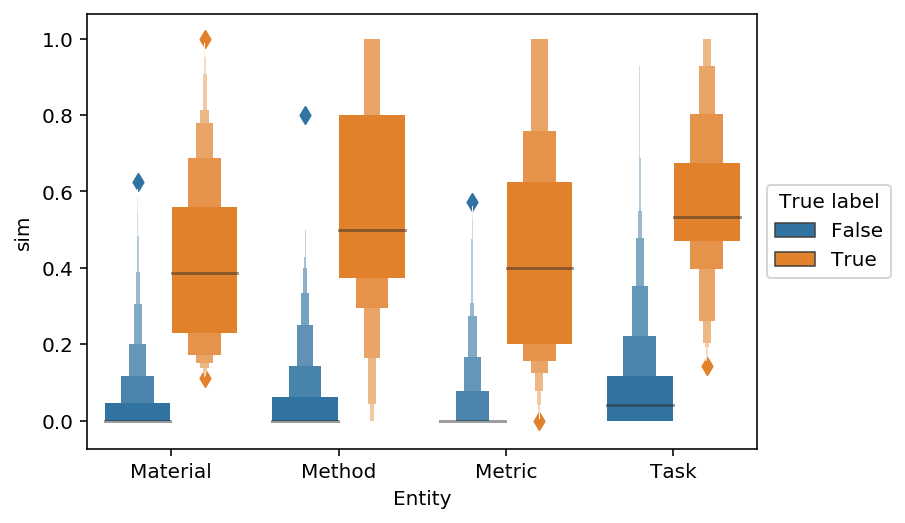

,n_pred,n_true,precision,recall,task,thresh,true_pred,f1
80,34,28,0.676471,0.821429,Material,0.202020,23,0.741935
141,58,44,0.586207,0.772727,Method,0.353535,34,0.666667
46,47,37,0.744681,0.945946,Metric,0.111111,35,0.833333
147,68,56,0.735294,0.892857,Task,0.363636,50,0.806452


In [50]:
scored_df = merged_df.apply(lambda row : get_scores(row, lambda x, y : char_sim(x, y, 3, True)), axis=1)
plot_similarity_histograms()
generate_stats()

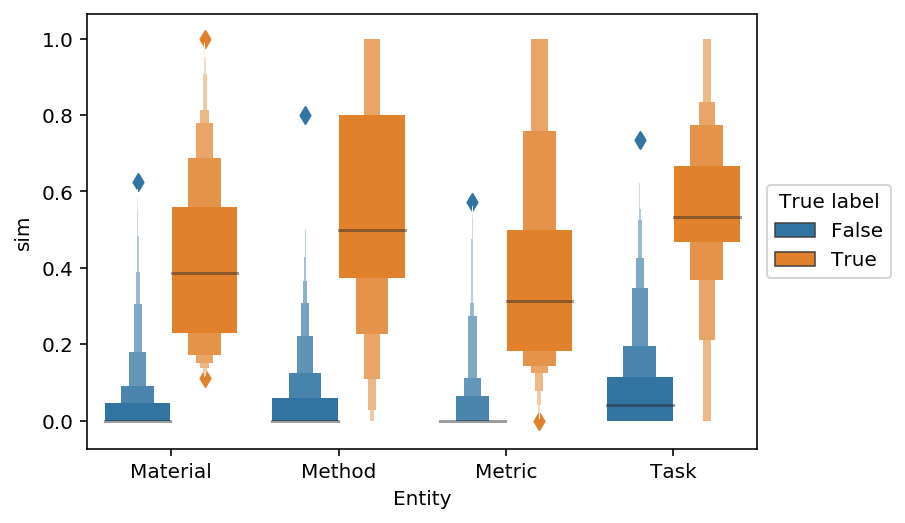

,n_pred,n_true,precision,recall,task,thresh,true_pred,f1
80,34,28,0.676471,0.821429,Material,0.202020,23,0.741935
149,50,44,0.660000,0.750000,Method,0.373737,33,0.702128
46,44,37,0.795455,0.945946,Metric,0.111111,35,0.864198
147,64,56,0.765625,0.875000,Task,0.363636,49,0.816667


In [49]:
scored_df = merged_df.apply(lambda row : get_scores(row, lambda x, y : char_sim(x, y, 3, False)), axis=1)
plot_similarity_histograms()
generate_stats()

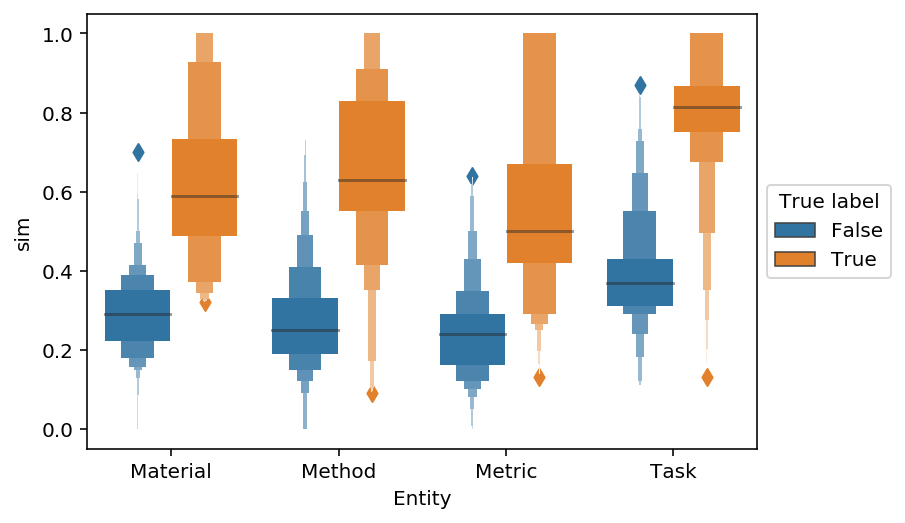

,n_pred,n_true,precision,recall,task,thresh,true_pred,f1
200,23,28,0.869565,0.714286,Material,0.505051,20,0.784314
229,54,44,0.537037,0.659091,Method,0.575758,29,0.591837
174,36,37,0.750000,0.729730,Metric,0.434343,27,0.739726
295,49,56,0.877551,0.767857,Task,0.737374,43,0.819048


In [32]:
scored_df = merged_df.apply(lambda row : get_scores(row, fuzzy_match_with_any), axis=1)
plot_similarity_histograms()
generate_stats()